<a href="https://colab.research.google.com/github/arman258/CNG-562/blob/master/MALEKLOO_malaria_cell_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!curl x-s https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: x-s
100   321  100   321    0     0    498      0 --:--:-- --:--:-- --:--:--  2395
Updating fastai...
Done.


In [0]:
import torch
print(torch.cuda.is_available())
torch.backends.cudnn.enabled

True


True

In [0]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria -p malaria --unzip -q

In [0]:
!ls malaria/cell_images

Parasitized  Uninfected


In [0]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np

In [0]:
!ls cell_images 

ls: cannot access 'cell_images': No such file or directory


In [0]:
path.ls()

[PosixPath('malaria/cell_images/Parasitized'),
 PosixPath('malaria/cell_images/Uninfected')]

In [0]:
path=Path('malaria/cell_images/')


In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20., max_zoom=0.05)

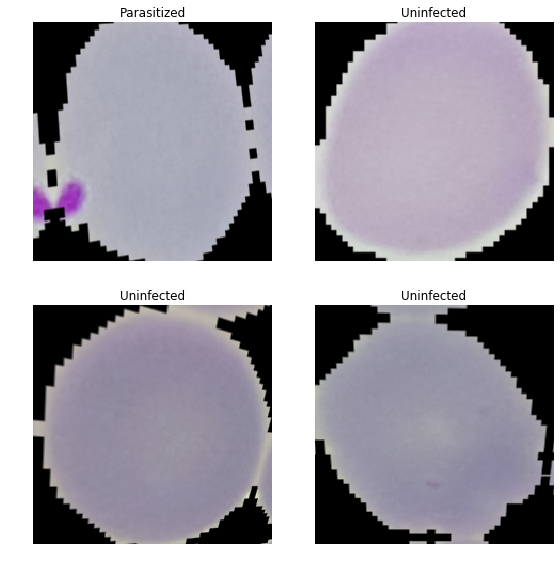

In [0]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=tfms,
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

data.show_batch(rows=2, figsize=(8,8))

In [0]:
print(data.classes)


['Parasitized', 'Uninfected']


In [0]:
data.label_list

LabelLists;

Train: LabelList (22047 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: malaria/cell_images;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Uninfected,Parasitized,Uninfected,Uninfected
Path: malaria/cell_images;

Test: None

In [0]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 17955984.72it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


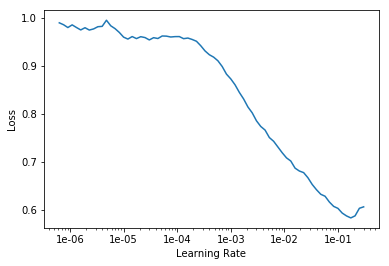

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.163306,0.145999,0.948285,04:59
1,0.157079,0.147788,0.958810,04:54
2,0.146519,0.110583,0.960987,04:54
3,0.119828,0.104705,0.964798,04:56
4,0.097023,0.087922,0.968427,04:51
5,0.106128,0.086315,0.968245,04:50


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


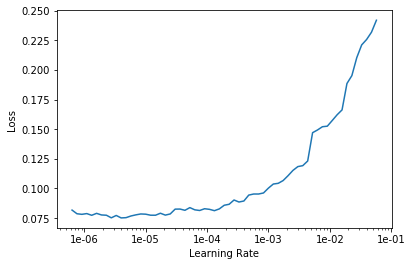

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,5e-5 ))


epoch,train_loss,valid_loss,accuracy,time
0,0.097257,0.085980,0.969516,05:28
1,0.103519,0.084766,0.968971,05:26
2,0.091938,0.080434,0.972056,05:26
3,0.094909,0.080252,0.969878,05:26


In [0]:
learn.save('model')


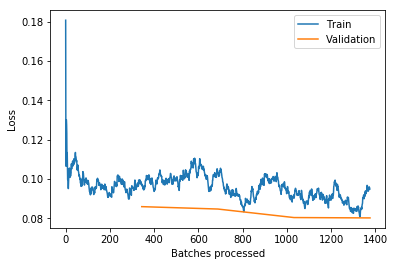

In [0]:
learn.recorder.plot_losses()


In [0]:
interp = ClassificationInterpretation.from_learner(learn)


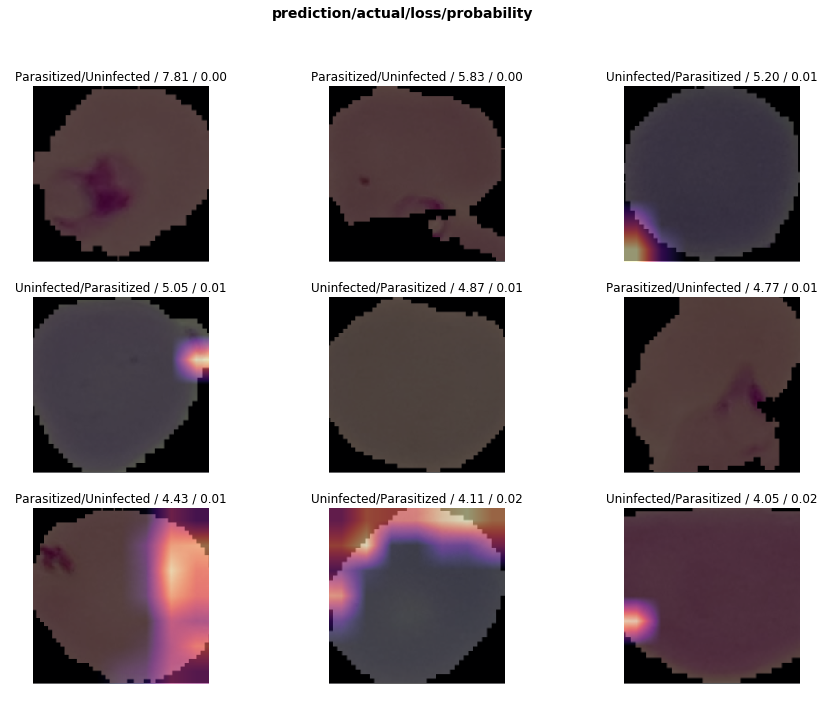

In [0]:
interp.plot_top_losses(9, figsize=(15,11))


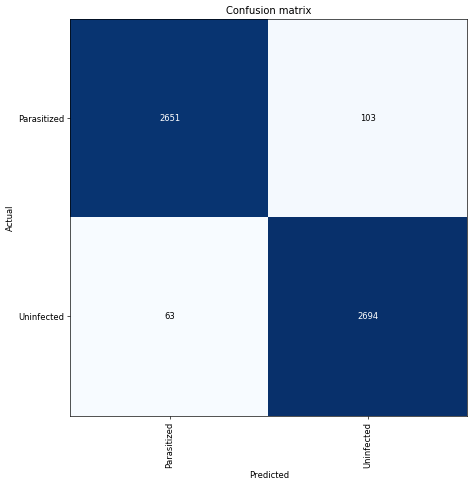

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)


In [0]:
ground_truth = []
pred_labels = []

for i in range(len(learn.data.valid_ds)):
  temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
  temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
  pred_labels.append(temp_pred)
  ground_truth.append(temp_truth)
  
assert len(pred_labels) == len(ground_truth)

from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_labels, target_names=data.classes))

              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      2754
  Uninfected       0.96      0.98      0.97      2757

   micro avg       0.97      0.97      0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



KERAS

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt 
import numpy as np

import cv2
import glob
import os


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
infected = os.listdir('malaria/cell_images/Parasitized/')
path_infected = 'malaria/cell_images/Parasitized/'
uninfected = os.listdir('malaria/cell_images/Uninfected/')
path_uninfected = 'malaria/cell_images/Uninfected/'


In [0]:
path_infected

'malaria/cell_images/Parasitized/'

In [0]:
print (f" infected {infected[:2]} \n\n uninfected {uninfected[:2]}")

 infected ['C101P62ThinF_IMG_20150918_155731_cell_67.png', 'C175P136NThinF_IMG_20151127_141253_cell_249.png'] 

 uninfected ['C178P139NThinF_IMG_20151201_155012_cell_83.png', 'C138P99ThinF_IMG_20151005_170905_cell_108.png']


In [0]:
# data =[]
# label = []
# for a in infected:
#   try:
#     image_read = cv2.imread('malaria/cell_images/Parasitized/'+a)
#     image_resize = cv2.resize(image_read, (50,50))
#     data.append(image_resize)
#     label.append(1)
#   except Exception as Error:
#     print(Error)
    
# for a in infected:
#   try:
#     image_read = cv2.imread('malaria/cell_images/Uninfected/'+a)
#     image_resize = cv2.resize(image_read, (50,50))
#     data.append(image_resize)
#     label.append(0)
#   except Exception as Error:
#     print(Error)

In [0]:
def resize(path):

  img =sorted(glob.glob(path+"*.png"))
  data =[]
  for a in img:
    try:
      image_read = cv2.imread(a,1)
      image_resize = cv2.resize(image_read, (128,128))
      data.append(image_resize)
    except Exception as Error:
      print(Error)
  return np.asarray(data)

In [0]:
X_infected = resize(path_infected)

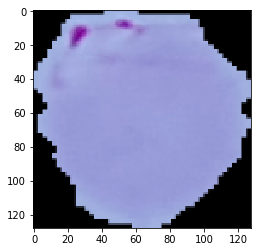

In [0]:
plt.imshow(X_infected[2])

In [0]:
height, width = X_infected.shape[:2]


NameError: ignored

In [0]:
X_uninfected = resize(path_uninfected)

In [0]:
X = np.vstack((X_uninfected, X_infected))


In [0]:
X.shape

(27558, 128, 128, 3)

In [0]:
labels = [0]*X_uninfected.shape[0] + [1]*X_infected.shape[0]


In [0]:
set(labels)

{0, 1}

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.25)


  


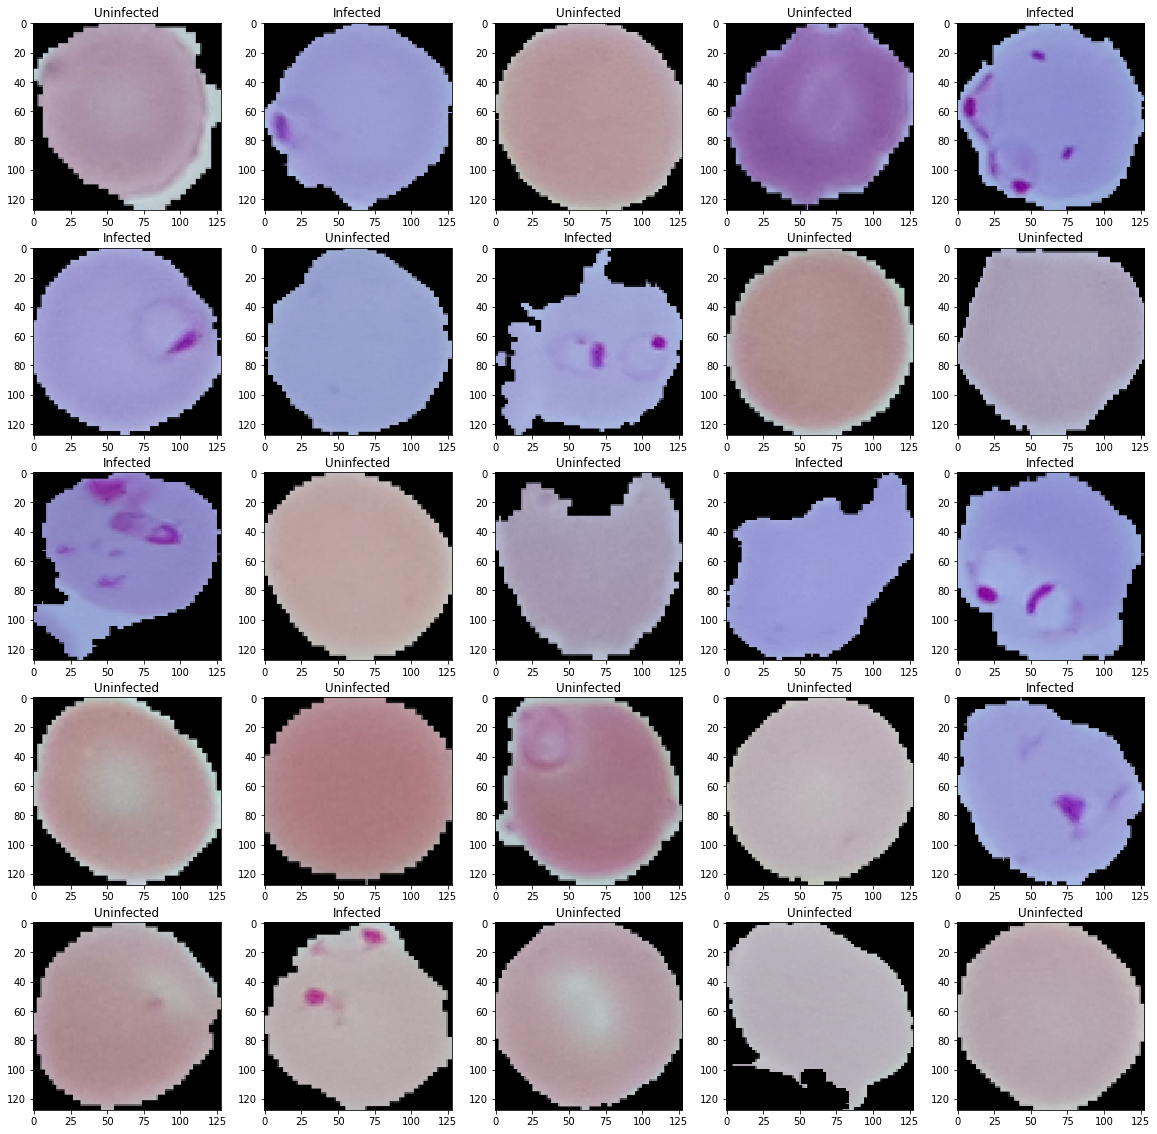

In [0]:
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i])
    if y_train[i] == 0:
        plt.title('Uninfected')
    else:
        plt.title('Infected')
    
plt.show()

In [0]:
inputShape= (128,128,3)


In [0]:
model = Sequential()
model.add(Conv2D(10, kernel_size=5, padding="same", input_shape=inputShape, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(20, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(30, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(500, kernel_size=3, padding="same", activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#model.add(Conv2D(1024, kernel_size=3, padding="valid", activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=5, activation='relu'))
#model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 10)      760       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 30)        5430      
_________________________________________________________________
max_pooling2d_3 (MaxP

In [0]:
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)


Train on 20668 samples, validate on 6890 samples
Epoch 1/20
20668/20668 [==============================] - 10s 495us/step - loss: 0.7205 - acc: 0.5092 - val_loss: 0.6759 - val_acc: 0.5977
Epoch 2/20
20668/20668 [==============================] - 9s 431us/step - loss: 0.6689 - acc: 0.5914 - val_loss: 0.6484 - val_acc: 0.6242
Epoch 3/20
20668/20668 [==============================] - 9s 434us/step - loss: 0.6472 - acc: 0.6225 - val_loss: 0.6310 - val_acc: 0.6525
Epoch 4/20
20668/20668 [==============================] - 9s 430us/step - loss: 0.6329 - acc: 0.6373 - val_loss: 0.6224 - val_acc: 0.6647
Epoch 5/20
20668/20668 [==============================] - 9s 430us/step - loss: 0.6192 - acc: 0.6556 - val_loss: 0.6156 - val_acc: 0.6624
Epoch 6/20
20668/20668 [==============================] - 9s 444us/step - loss: 0.5999 - acc: 0.6742 - val_loss: 0.6149 - val_acc: 0.6649
Epoch 7/20
20668/20668 [==============================] - 9s 441us/step - loss: 0.5799 - acc: 0.6917 - val_loss: 0.6246 - 

In [0]:
import tensorflow as tf
tf.__version__

'1.13.1'

In [0]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
___________________________

In [0]:
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

    


Train on 20668 samples, validate on 6890 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
20668/20668 [==============================] - 59s 3ms/sample - loss: 1.2087 - acc: 0.7906 - val_loss: 0.3399 - val_acc: 0.9205
Epoch 2/20
20668/20668 [==============================] - 53s 3ms/sample - loss: 0.5447 - acc: 0.8772 - val_loss: 0.2673 - val_acc: 0.9241
Epoch 3/20
20668/20668 [==============================] - 55s 3ms/sample - loss: 0.4003 - acc: 0.8972 - val_loss: 0.2469 - val_acc: 0.9283
Epoch 4/20
20668/20668 [==============================] - 55s 3ms/sample - loss: 0.3265 - acc: 0.9092 - val_loss: 0.2143 - val_acc: 0.9308
Epoch 5/20
20668/20668 [==============================] - 56s 3ms/sample - loss: 0.2755 - acc: 0.9174 - val_loss: 0.2076 - val_acc: 0.9347
Epoch 6/20
20668/20668 [==============================] - 56s 3ms/sample - loss: 0.2489 - acc: 0.9244 - val_loss: 0.1980 - val_acc: 0.9372
Epoch 7/20
20668/20668 [==============================] - 56s 3ms/sam

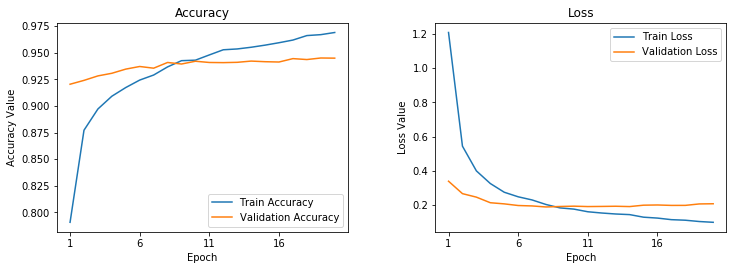

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(H.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, H.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, H.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")